In [1]:
library(rliger)
library(viridis)
library(Seurat)
library(ggplot2)
library(gridExtra)

Loading required package: cowplot

Loading required package: Matrix

Loading required package: patchwork


Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots


Loading required package: viridisLite

Attaching SeuratObject

Attaching sp



In [2]:
#if using ARCHR outputs, start here instead
D5T1 <- read.csv("MERGED_PEER/AML7_MERGE_all_cells_gene_scores.csv",row.names=1)

In [3]:
D5T <- log2(D5T1 + 1)

In [4]:
bmmc.rna <- t(read.csv("AML7_MERGE_COUNTS.csv",row.names=1))

In [5]:
bmmc.data <- list(atac = D5T, rna = bmmc.rna)

In [6]:
int.bmmc <- createLiger(bmmc.data)
#rm(genes.bc, promoters.bc, gene.counts, promoter.counts, D5T1, bmmc.rna, bmmc.data)
gc()

Removing 154 genes not expressing in atac.



used       (Mb)    gc trigger (Mb)    max used   (Mb)   
Ncells    3466664   185.2    6349615   339.2    6349615   339.2
Vcells 1425271138 10874.0 2918773140 22268.5 2692335915 20540.9

In [7]:
int.bmmc <- normalize(int.bmmc)
int.bmmc <- selectGenes(int.bmmc, datasets.use = 2)
int.bmmc <- scaleNotCenter(int.bmmc)

In [8]:
int.bmmc <- optimizeALS(int.bmmc, k = 20)

  |======================================================================| 100%
Finished in 18.29947 mins, 30 iterations.
Max iterations set: 30.
Final objective delta: 5.938823e-05.
Best results with seed 1.


In [9]:
int.bmmc <- quantile_norm(int.bmmc)

In [10]:
int.bmmc <- louvainCluster(int.bmmc, resolution = 0.2)

Louvain Clustering on quantile normalized cell factor loadings.



In [11]:
int.bmmc <- runUMAP(int.bmmc, distance = 'cosine', n_neighbors = 30, min_dist = 0.3)

In [12]:
plots <- plotByDatasetAndCluster(int.bmmc, axis.labels = c('UMAP 1', 'UMAP 2'),return.plots=TRUE)
ggsave("figures/AML7_LIGER_MERGEDSPACE.eps",plots[[1]],device="eps")

Saving 6.67 x 6.67 in image



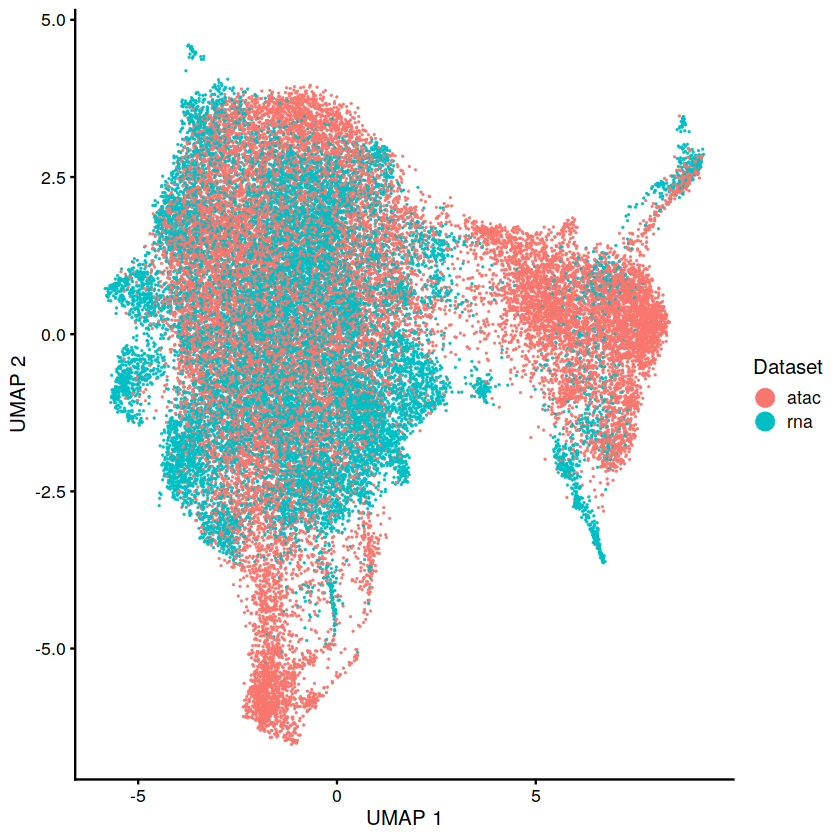

In [13]:
plots[[1]]

In [14]:
genes <- c('NPM1','PROM1','AVP','CD34','MPO','GATA1')
for (gene in genes){
    plots <- plotGene(int.bmmc, gene, axis.labels = c('UMAP 1', 'UMAP 2'),pt.size=.5, return.plots = TRUE)
    fname_atac <- paste("figures/liger_markers/AML7_LIGER_ATAC_",gene,sep="")
    fname_rna <- paste("figures/liger_markers/AML7_LIGER_RNA_",gene,sep="")
    ggsave(paste(fname_atac,".eps",sep=""),plots[[1]],device="eps")
    ggsave(paste(fname_rna,".eps",sep=""),plots[[2]],device="eps")
    }

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



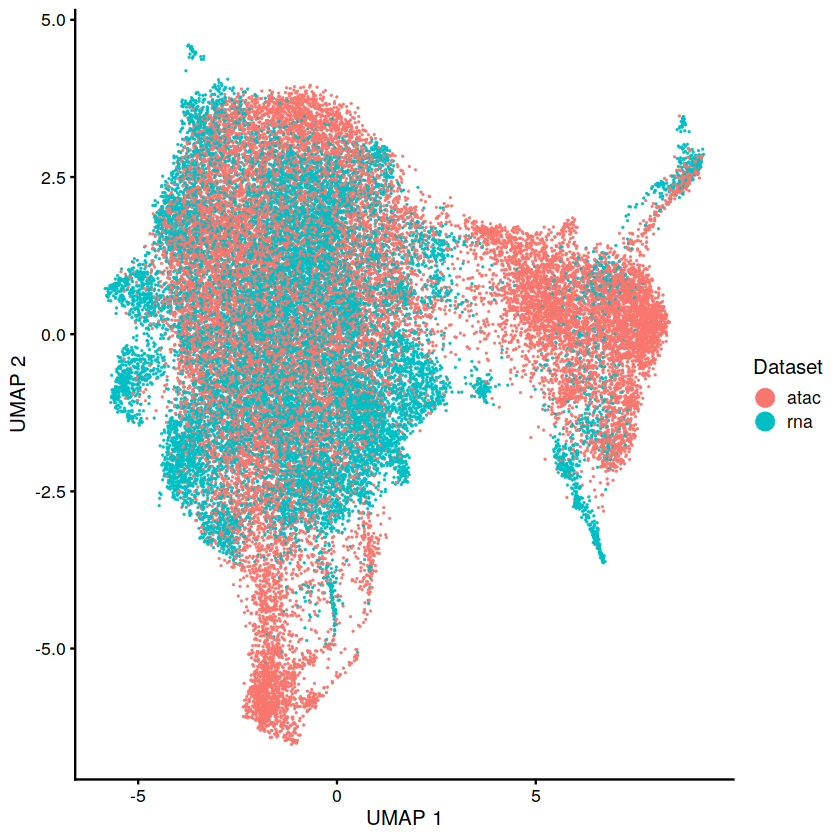

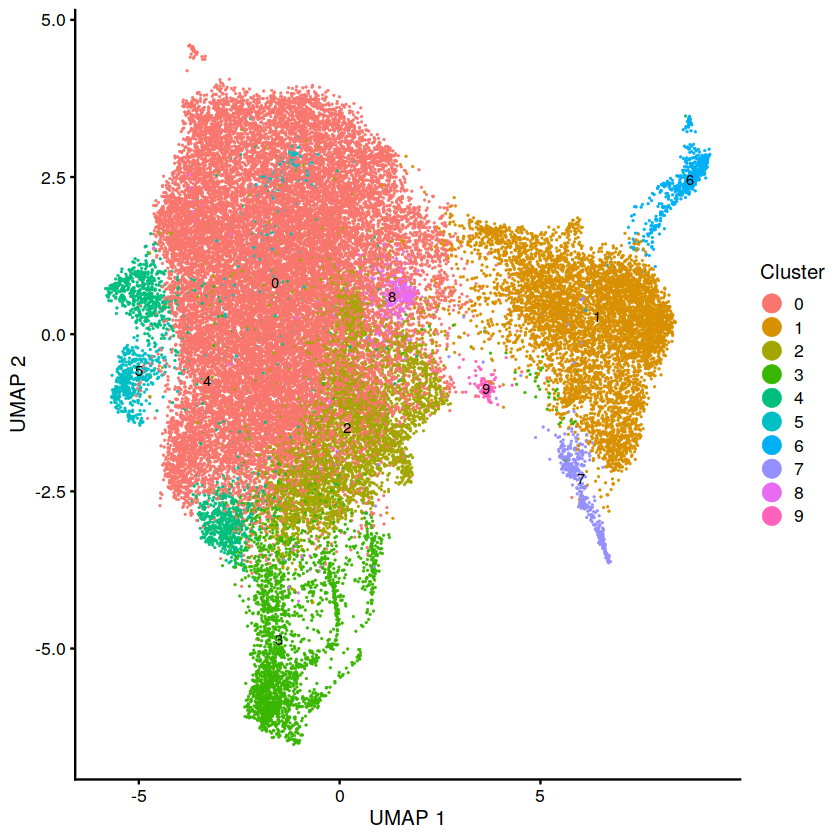

In [13]:
plotByDatasetAndCluster(int.bmmc, axis.labels = c('UMAP 1', 'UMAP 2'))

In [14]:
int.bmmc


An object of class liger 
with 2 datasets and
 40404 total cells.

In [15]:
int.bmmc.wilcoxon <- runWilcoxon(int.bmmc, data.use = 'all', compare.method = 'clusters')

Performing Wilcoxon test on ALL datasets: atac, rna



In [16]:
int.bmmc.wilcoxon <- int.bmmc.wilcoxon[int.bmmc.wilcoxon$padj < 0.05,]
int.bmmc.wilcoxon <- int.bmmc.wilcoxon[int.bmmc.wilcoxon$logFC > 3,]
wilcoxon.cluster_1 <- int.bmmc.wilcoxon[int.bmmc.wilcoxon$group == 1, ]
wilcoxon.cluster_1 <- wilcoxon.cluster_1[order(wilcoxon.cluster_1$padj), ]
markers.cluster_1 <- wilcoxon.cluster_1[1:20, ]

In [17]:
write.csv(int.bmmc@H.norm,'AML7_MERGED_LIGER_H.norm.csv')

In [25]:
graphs <- FindNeighbors(int.bmmc@H.norm[1:dim(D5T)[2],],k.param=10)

Computing nearest neighbor graph

Computing SNN



In [26]:
adjacency <- as.matrix(graphs$nn)

In [27]:
adj = colnames(adjacency)
orig = colnames(D5T)
for (x in dim(colnames(adjacency))){
    if (adj[x]!=orig[x]){
        print("MISMATCH")
    }
}

In [22]:
smoothing <- function(gene, adjacency) {    
    data <- t(D5T[gene,])
    upper <- dim(adjacency)[1]
    means <- c()
    for (y in 1:upper){
        test <- adjacency[y,]
        vals <- c()
        #if (y %% 1000==0){
        #    message(y)
        #}
        for (x in 1:upper) {
            if (test[x] == 1) {
                #vals <- cbind(vals, data[colnames(adjacency[y,][x]),])
                vals <- cbind(vals, data[x,])
            }
        }
        means <- cbind(means, mean(vals))
    }

    data = t(means)

    to_plot <- as.data.frame(cbind(int.bmmc@tsne.coords[1:dim(D5T)[2],],data))
    colnames(to_plot) <- c("X0","X1","ATAC")

    return(to_plot)
}

In [21]:
data = t(means)

library(ggplot2)
sc <- scale_colour_gradient(limits=c(1, 8))

to_plot <- as.data.frame(cbind(int.bmmc@tsne.coords[1:dim(D5T)[2],],data))
colnames(to_plot) <- c("X0","X1","ATAC")

ggplot(to_plot, aes(x=X0, y=X1, color=ATAC))+ geom_point(size=.1)+theme_classic()+scale_color_viridis(option="B",na.value="#D2D2D2",limit=c(0,1.5))+ggtitle("PROM1") 

ERROR: Error in h(simpleError(msg, call)): error in evaluating the argument 'x' in selecting a method for function 't': object 'means' not found


In [18]:
to_plot <- as.data.frame(cbind(int.bmmc@tsne.coords[1:dim(D5T)[2],]))
colnames(to_plot) <- c("X0","X1")

In [19]:
write.csv(to_plot,"AML7_MERGED_LIGER_ATAC_TSNE.csv")

In [20]:
rna<-as.data.frame(t(int.bmmc@scale.data$rna))
make_both <- function(rna, gene, atac_plot, upper_atac=1.5, upper=3) {  
    to_plot2 <- as.data.frame(cbind(int.bmmc@tsne.coords[(dim(D5T)[2]+1):dim(int.bmmc@tsne.coords)[1],],t(rna[gene,])))
    colnames(to_plot2) <- c("X0","X1","RNA")
    p1<-ggplot(atac_plot, aes(x=X0, y=X1, color=ATAC))+ geom_point(size=.05)+theme_classic()+scale_color_viridis(option="A",na.value="#D2D2D2",limit=c(0,upper_atac))+ggtitle(gene) 
    p2<-ggplot(to_plot2, aes(x=X0, y=X1, color=RNA))+ geom_point(size=.05)+theme_classic()+scale_color_viridis(option="A",na.value="#D2D2D2",limit=c(0,upper))+ggtitle(gene) 
    
    rna<-t(rna[gene,])
    rna[rna == 0] <- NA

    nas <- c()
    notnas <- c()
    for (x in 1:dim(rna)[1]) {
      if (is.na(rna[x])){
          nas <- cbind(nas, x)
      }   
      else{
          notnas <- cbind(notnas, x)
      }
    }

    to_plot3 <- as.data.frame(cbind(int.bmmc@tsne.coords[(dim(D5T)[2]+1):dim(int.bmmc@tsne.coords)[1],][nas,],rna[nas]))
    colnames(to_plot3) <- c("X0","X1","RNA")

    to_plot4 <- as.data.frame(cbind(int.bmmc@tsne.coords[(dim(D5T)[2]+1):dim(int.bmmc@tsne.coords)[1],][notnas,],rna[notnas]))
    colnames(to_plot4) <- c("X0","X1","RNA")

    to_plot5 <- rbind(to_plot3, to_plot4)
    p3<-ggplot(to_plot5, aes(x=X0, y=X1, color=RNA))+ geom_point(size=.05)+theme_classic()+scale_color_viridis(option="A",na.value="#D2D2D2",limit=c(0,upper))+ggtitle(gene) 
    
    
    ligers <- plotGene(int.bmmc, gene, axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = TRUE)
    
    plot_grid(p1,p2,ligers[[2]],p3,ncol=2)
    
}

In [28]:
atac<-smoothing("CD34",adjacency)

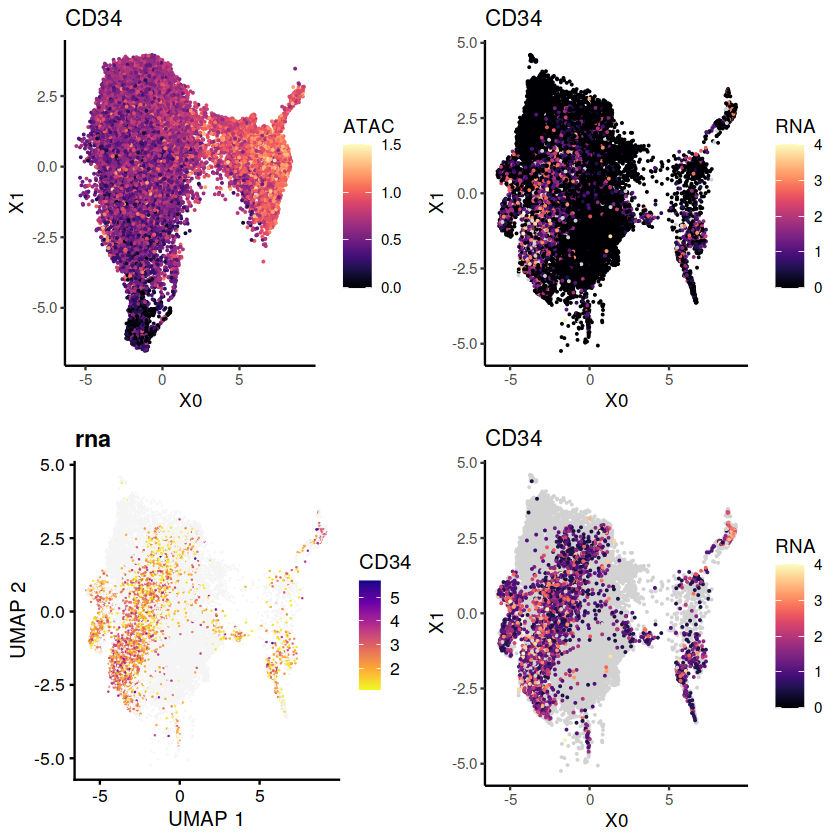

In [29]:
make_both(rna, "CD34", atac,upper_atac=1.5, upper=4)

In [30]:
atac<-smoothing("PROM1",adjacency)

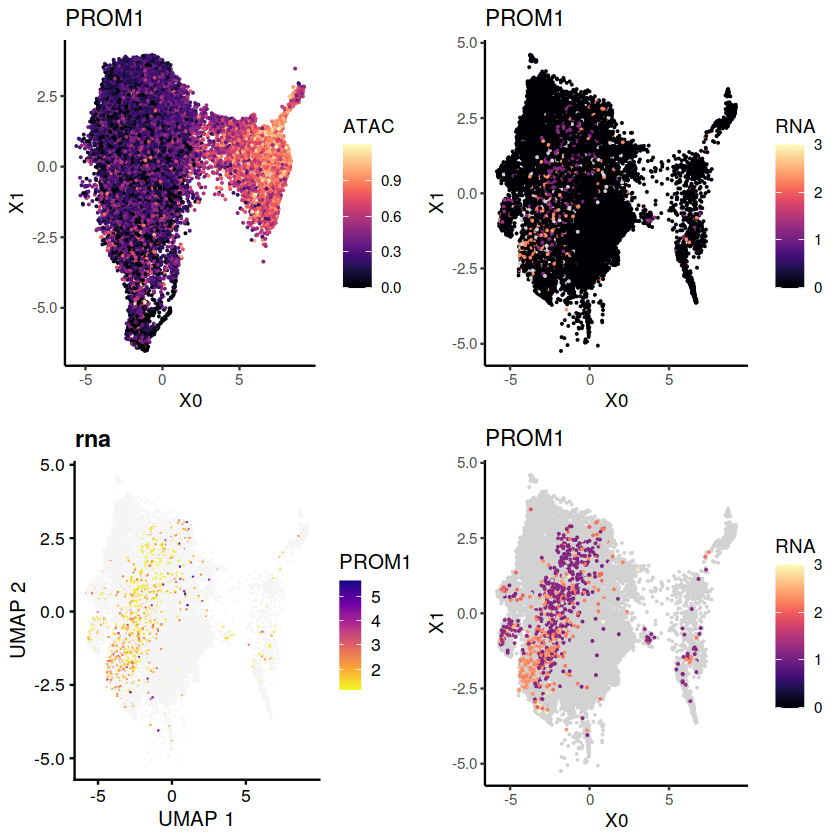

In [31]:
make_both(rna, "PROM1", atac,upper_atac=1.2)

In [32]:
atac<-smoothing("AVP",adjacency)

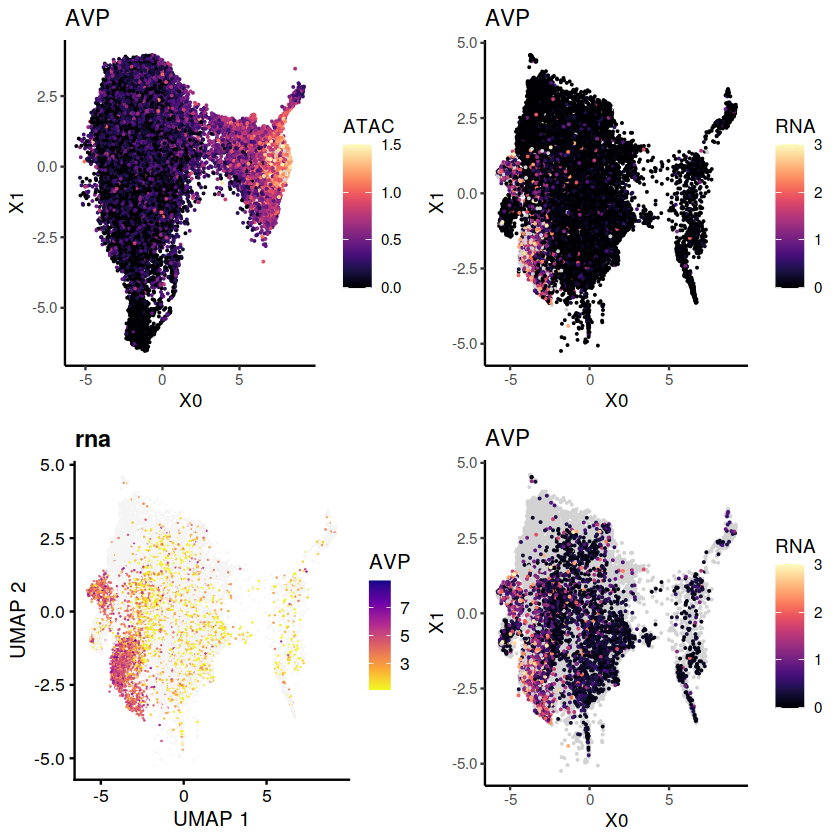

In [33]:
make_both(rna, "AVP", atac)

In [ ]:
atac<-smoothing("LYZ",adjacency)

In [ ]:
make_both(rna, "LYZ", atac)

In [ ]:
atac<-smoothing("NPM1",adjacency)

In [ ]:
make_both(rna, "NPM1", atac,upper_atac=1)

In [ ]:
atac<-smoothing("CD14",adjacency)

In [ ]:
make_both(rna, "CD14", atac,upper_atac=2)

In [ ]:
atac<-smoothing('FOSL2',adjacency)

In [ ]:
make_both(rna, "FOSL2", atac,upper_atac=2)

In [ ]:
atac<-smoothing('JUND',adjacency)

In [ ]:
make_both(rna, "JUND", atac,upper_atac=2)

In [ ]:
atac<-smoothing('MAFF',adjacency)

In [ ]:
make_both(rna, 'MAFF', atac,upper_atac=1)

In [32]:
atac<-smoothing('MXD1',adjacency)

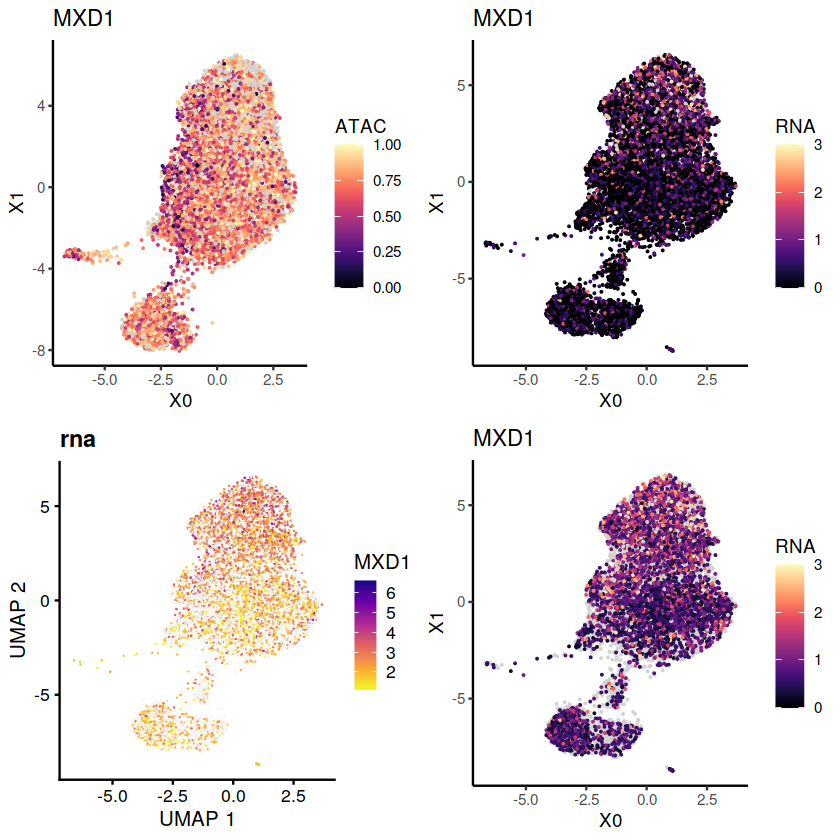

In [33]:
make_both(rna, 'MXD1', atac,upper_atac=1)

In [36]:
atac<-smoothing('PRDM1',adjacency)

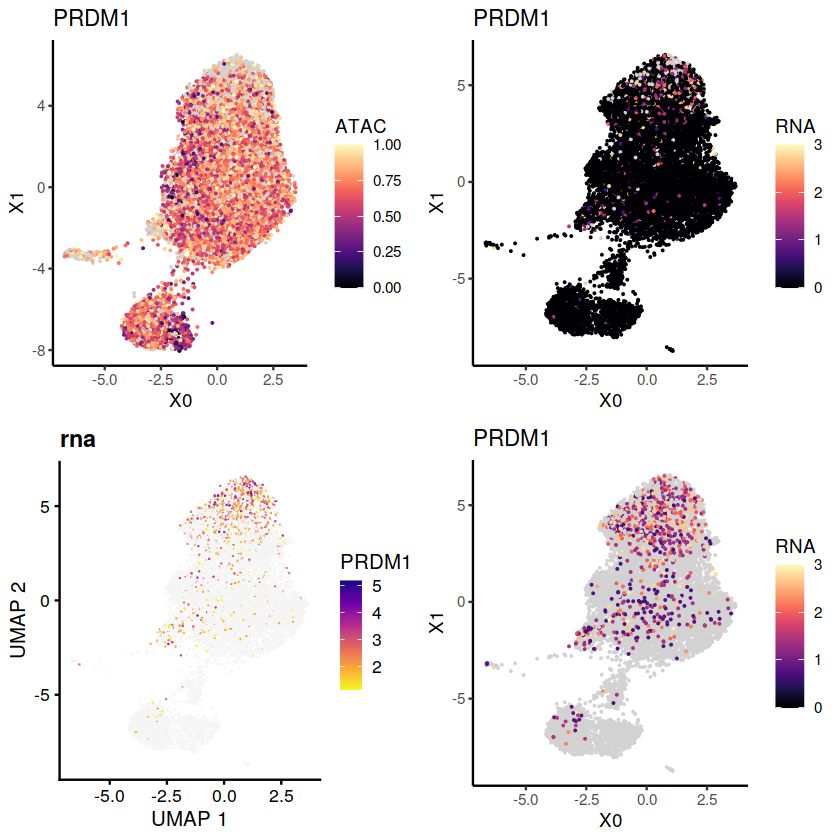

In [37]:
make_both(rna, 'PRDM1', atac,upper_atac=1)

In [252]:
annots <- read.csv("rawdata/counts/p89_rna_annots.csv")

In [300]:
dummy <- c()
for (x in 1:dim(D5T)[2]){
    dummy<-cbind(dummy, "N/A")
}

In [301]:
annotations<-cbind(dummy,t(as.data.frame(annots[["blast_cell_type_08H089"]])))

In [325]:
check<-rownames(int.bmmc@tsne.coords)
for (x in 1:length(annotations)){
    if (annotations[x]!="N/A"){
        if (annots[["index"]][x]!=check[x]){
            print(x)
        }
    }
}

ERROR: Error in if ((annots[["index"]][x] == check[x]) == FALSE) {: missing value where TRUE/FALSE needed


New names:
* NA -> ...1
* NA -> ...2
* NA -> ...3



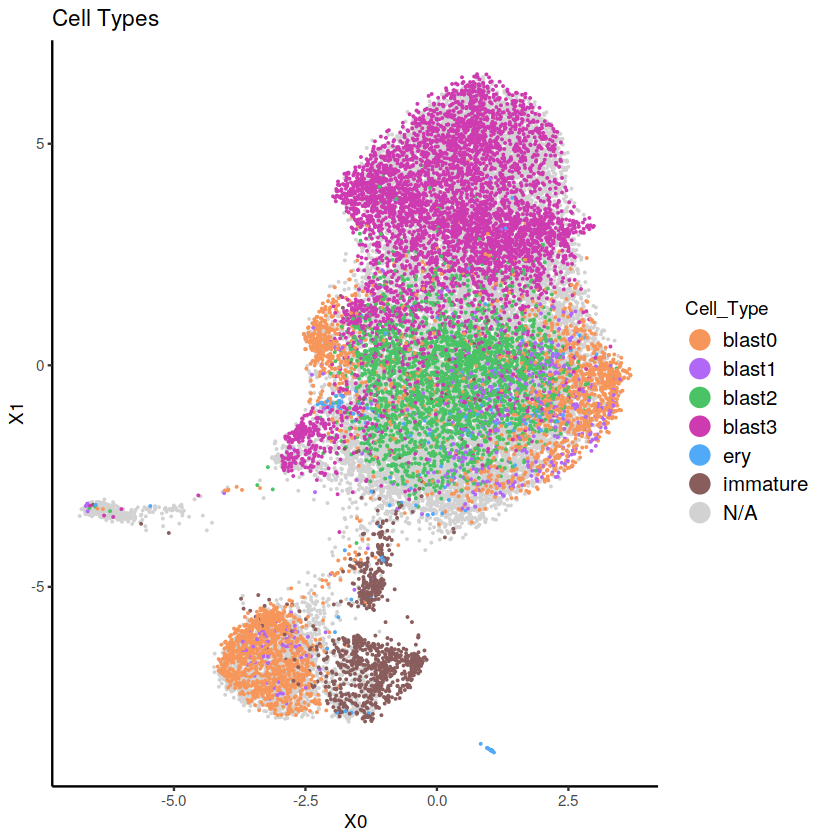

In [309]:
to_plot <- as.data.frame(bind_cols(int.bmmc@tsne.coords[,1],int.bmmc@tsne.coords[,2],t(annotations)))
colnames(to_plot) <- c("X0","X1","Cell_Type")
ggplot(to_plot, aes(x=X0, y=X1, color=Cell_Type))+ geom_point(size=.05)+theme_classic()+ggtitle("Cell Types")+guides(colour = guide_legend(override.aes = list(size=5)))+  theme(legend.text = element_text(size=12))+scale_color_manual(values=c("#F7965A", "#B168F6","#49C365", "#CE3AAF", "#50AAF8","#8A5D5D","#D2D2D2"))


In [83]:
#WITHOUT SMOOTHING
manual_atac <- function(gene, upper=2.5) { 
    #data = t(D5T[gene,])
    data = means

    data[data == 0] <- NA

    nas <- c()
    notnas <- c()
    for (x in 1:dim(data)[1]) {
      if (is.na(data[x])){
          nas <- cbind(nas, x)
      }   
      else{
          notnas <- cbind(notnas, x)
      }
    }

    library(ggplot2)
    sc <- scale_colour_gradient(limits=c(1, 8))

    to_plot <- as.data.frame(cbind(int.bmmc@tsne.coords[1:dim(D5T)[2],][nas,],data[nas]))
    colnames(to_plot) <- c("X0","X1","ATAC")

    to_plot2 <- as.data.frame(cbind(int.bmmc@tsne.coords[1:dim(D5T)[2],][notnas,],data[notnas]))
    colnames(to_plot2) <- c("X0","X1","ATAC")

    to_plot3 <- rbind(to_plot, to_plot2)
    ggplot(to_plot3, aes(x=X0, y=X1, color=ATAC))+ geom_point(size=.1)+theme_classic()+scale_color_viridis(option="A",na.value="#D2D2D2",limit=c(0,upper))+ggtitle(gene) 
    #ggplot(to_plot2, aes(x=X0, y=X1, color=PROM1))+ geom_point(size=.1)+theme_classic()+scale_color_viridis(option="A",na.value="#F5F5F5")
}

In [66]:
slotNames(int.bmmc)

[1] "raw.data"           "norm.data"          "scale.data"        
 [4] "sample.data"        "h5file.info"        "cell.data"         
 [7] "var.genes"          "H"                  "H.norm"            
[10] "W"                  "V"                  "A"                 
[13] "B"                  "tsne.coords"        "alignment.clusters"
[16] "clusters"           "agg.data"           "parameters"        
[19] "snf"                "version"

In [84]:
write.csv(int.bmmc@tsne.coords,"LIGER_umap_coords.csv")

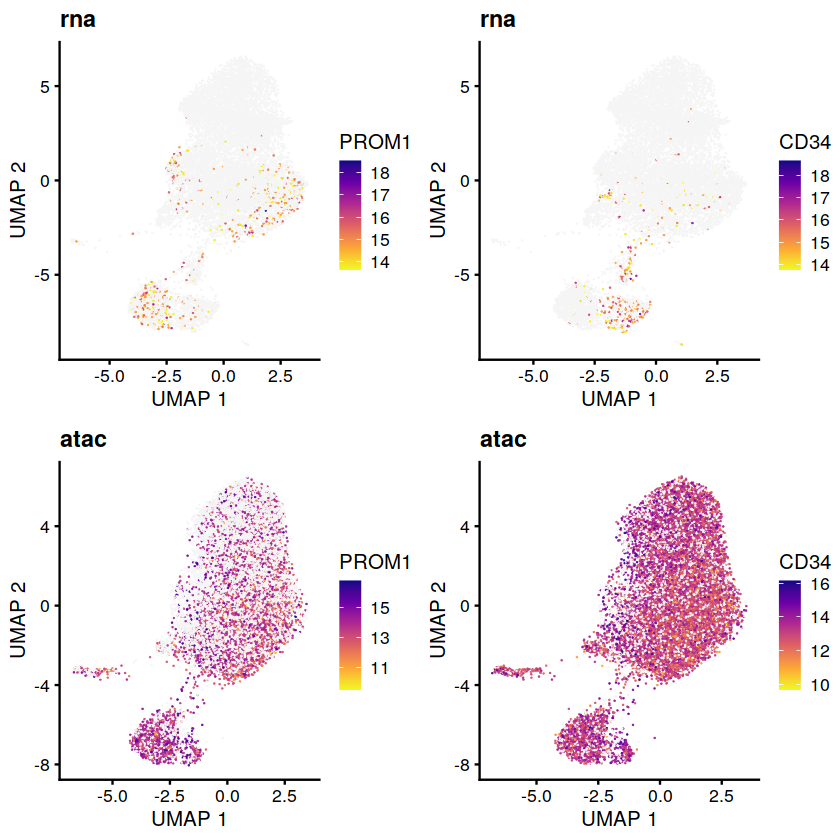

In [230]:
plot_by_name('PROM1','CD34')

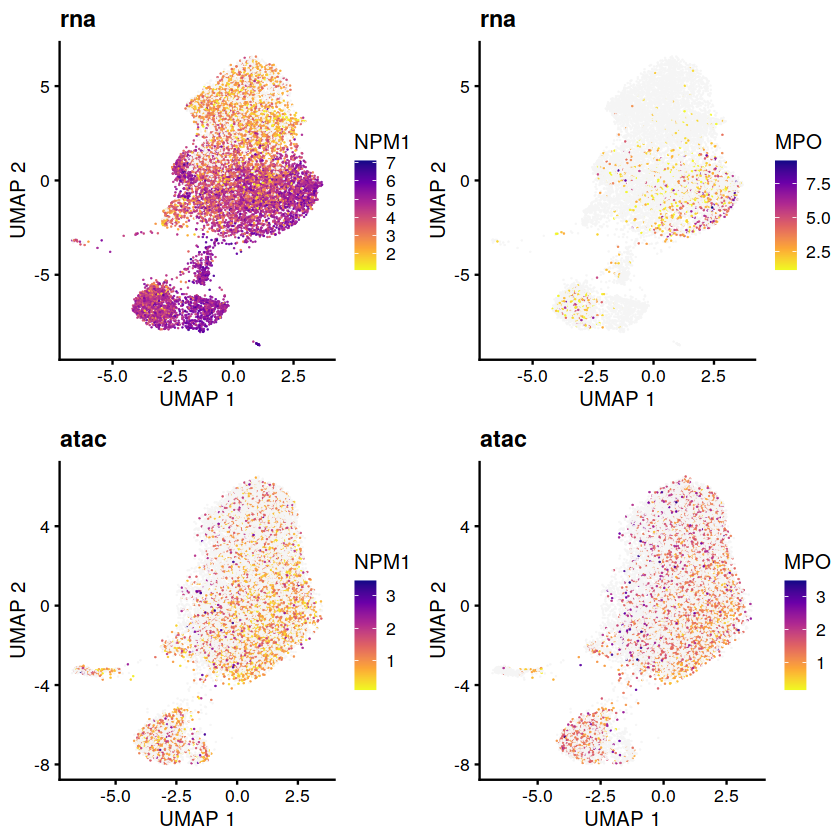

In [27]:
NPM1 <- plotGene(int.bmmc, "NPM1", axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = TRUE)
MPO <- plotGene(int.bmmc, "MPO", axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = TRUE)
plot_grid(NPM1[[2]],MPO[[2]],NPM1[[1]],MPO[[1]], ncol=2)

In [99]:
degs <- c()
for (x in 0:10) {
    wilcoxon.cluster_x <- int.bmmc.wilcoxon[int.bmmc.wilcoxon$group == x, ]
    wilcoxon.cluster_x <- wilcoxon.cluster_x[order(wilcoxon.cluster_x$padj), ]
    markers.cluster_x <- wilcoxon.cluster_x[1:20, ]
    degs <- append(degs, markers.cluster_x["feature"][,1][1])
}

In [100]:
degs

[1] "APOBEC3A" "ACP1"     "CTSG"     "CTSD"     "AURKB"    "ALDH1A1" 
 [7] "ABCC1"    "PKIB"     "BACH2"    "ELANE"    NA

In [144]:
plot_by_name <- function(gene1,gene2) {
    g1 <- plotGene(int.bmmc, gene1, axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = TRUE,use.scaled=TRUE)
    g2 <- plotGene(int.bmmc, gene2, axis.labels = c('UMAP 1', 'UMAP 2'), return.plots = TRUE,use.scaled=TRUE)
    plot_grid(g1[[2]],g2[[2]],g1[[1]],g2[[1]], ncol=2)
}

Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom



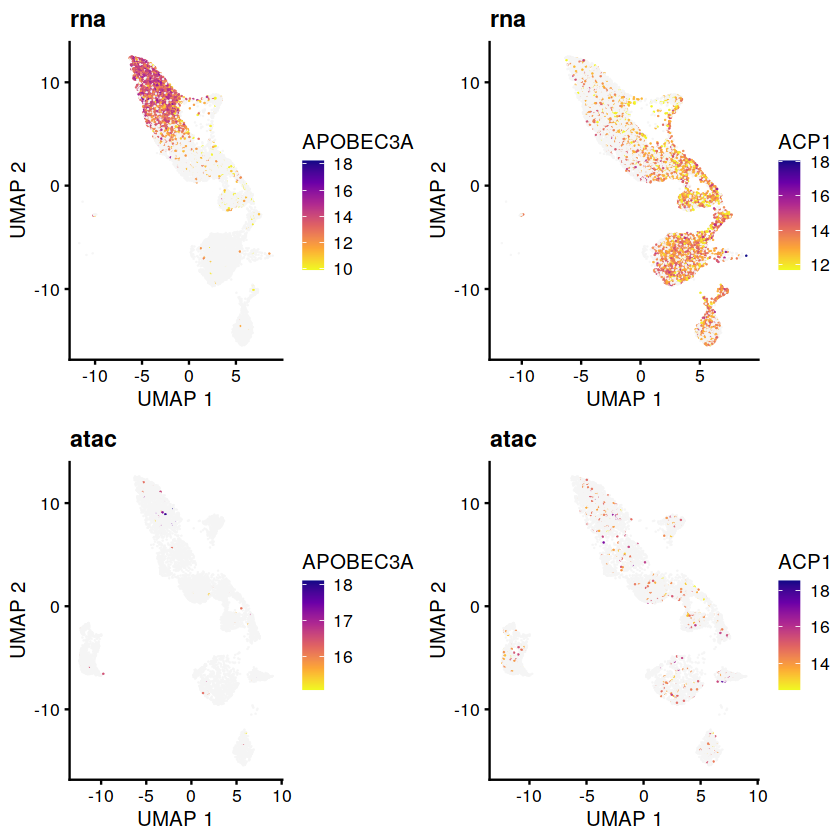

In [111]:
plot_by_name('APOBEC3A','ACP1')

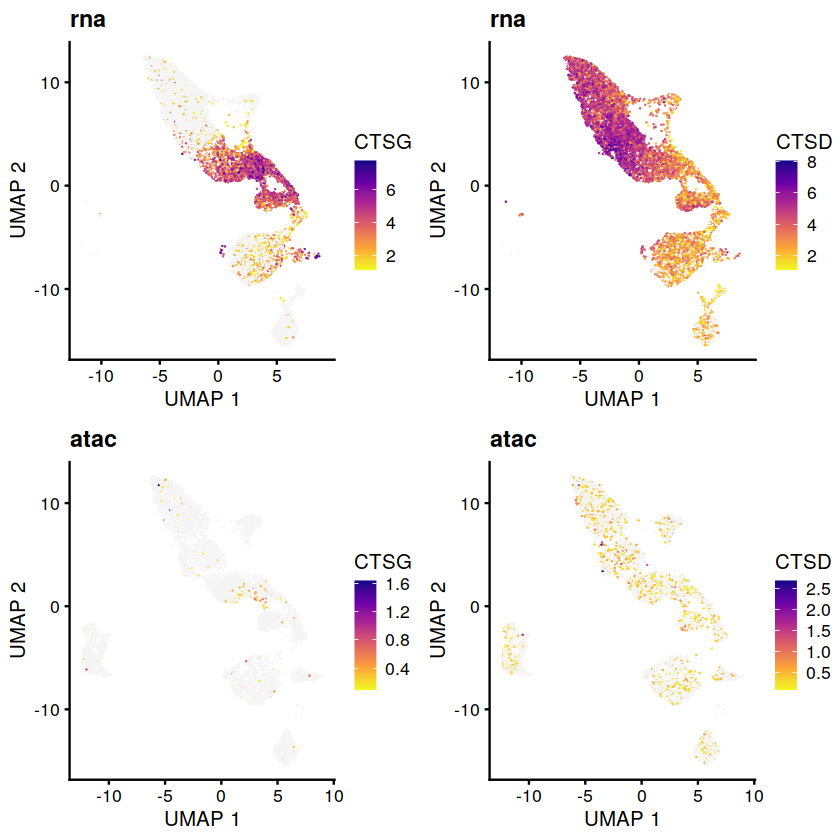

In [104]:
plot_by_name('CTSG','CTSD')

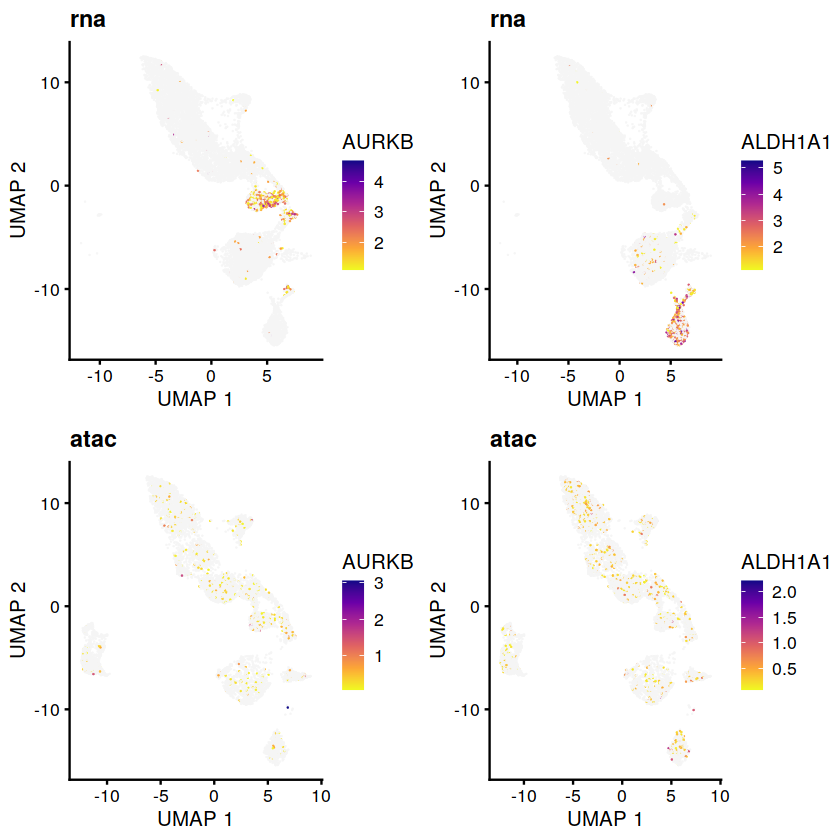

In [105]:
plot_by_name('AURKB','ALDH1A1')

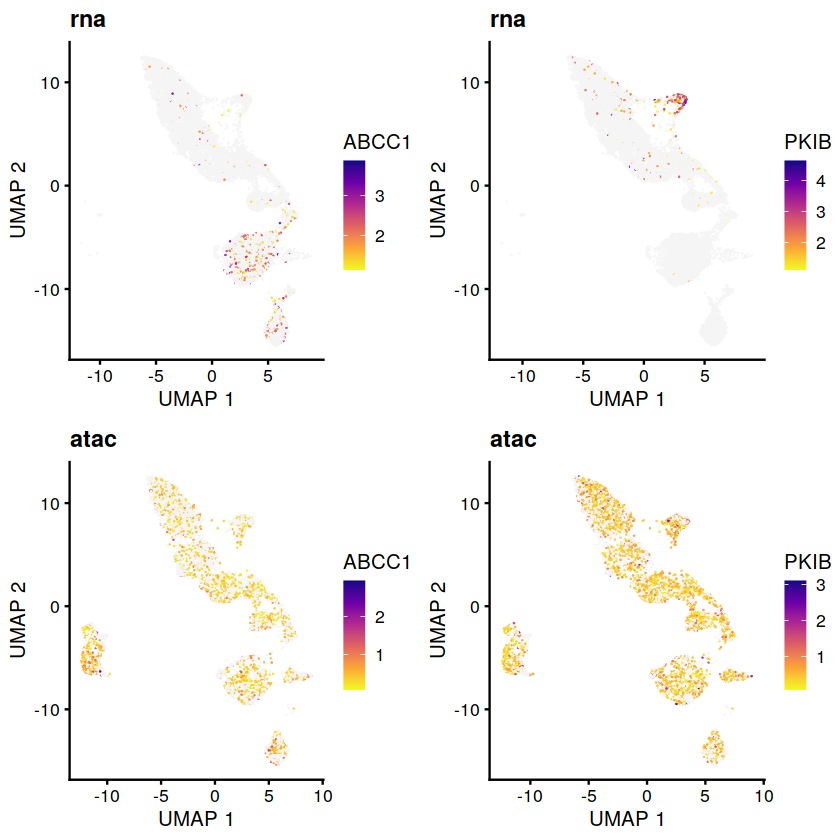

In [106]:
plot_by_name('ABCC1','PKIB')

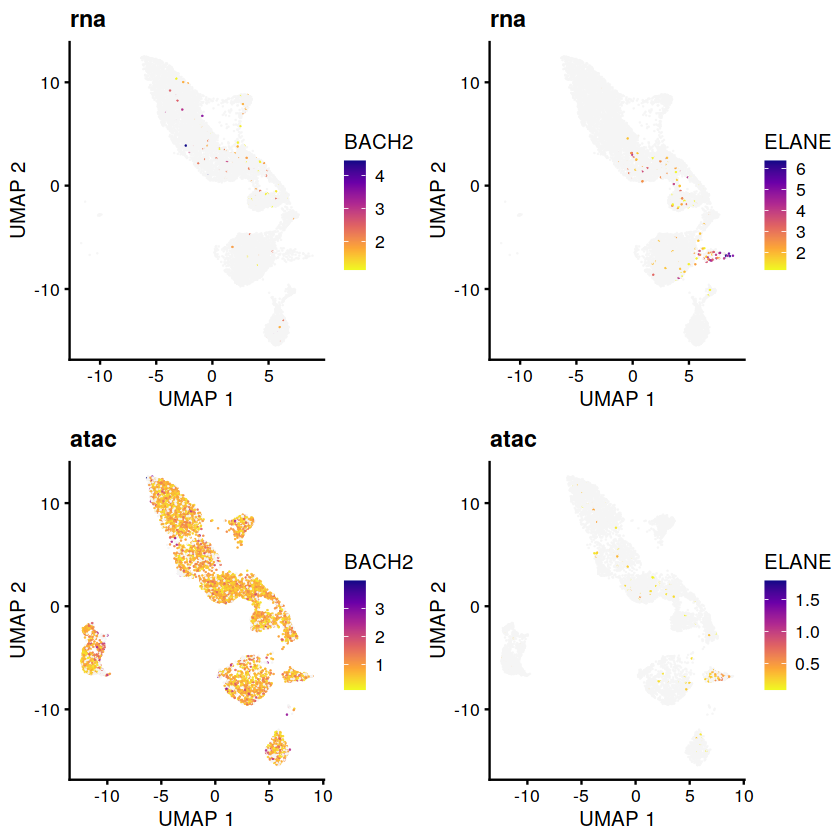

In [108]:
plot_by_name('BACH2','ELANE')

In [315]:
s.object <- ligerToSeurat(int.bmmc,renormalize=FALSE)

Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“No columnames present in cell embeddings, setting to 'iNMF_1:20'”
Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“No columnames present in cell embeddings, setting to 'tSNE_1:2'”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [316]:
saveRDS(s.object,"LIGER_from_archr.rds")

In [6]:
int.bmmc <- seuratToLiger(seurat,combined.seurat=TRUE,use.idents = T,
    use.tsne = T, meta.var = "orig.ident",)

Removing 200 genes not expressing in atac.

Removing 21831 genes not expressing in rna.

